In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Installing additional libraries for text preprocessing
!pip install -q preprocessor
!pip install -q contractions
!pip install emoji

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 6.6 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Text processing libraries
import emoji
import string
import re
import preprocessor
import contractions
from collections import Counter
import spacy
from spacy.lang.en.stop_words import STOP_WORDS


from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
# from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)

tqdm.pandas()

from wordcloud import WordCloud
from IPython.display import Image
from PIL import Image

In [ ]:
train_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles/full_dataset/train_dataset.csv'
validation_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles/full_dataset/validation_dataset.csv'
test_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles/full_dataset/test_dataset.csv'
#Loading datasets into DF
df_train = pd.read_csv(train_dataset_path)
validation_df = pd.read_csv(validation_dataset_path)
test1_df = pd.read_csv(test_dataset_path)

# Merge the datasets
df_test = pd.concat([validation_df, test1_df], ignore_index=True)

# Checking Shape
display(df_train.shape)
display(df_test.shape)

(147847, 30)

(63364, 30)

In [ ]:
# Function for cleaning text
def preprocess_corpus(text):
  re_number = re.compile('[0-9]+')
  re_url = re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")
  re_tag = re.compile('\[[A-Z]+\]')
  re_char = re.compile('[^0-9a-zA-Z\s?!.,:\'\"//]+')
  re_char_clean = re.compile('[^0-9a-zA-Z\s?!.,\[\]]')
  re_punc = re.compile('[?!,.\'\"]')

  text = re.sub(re_char, "", text) # Remove unknown character
  text = contractions.fix(text) # Expand contraction
  text = re.sub(re_url, ' [url] ', text) # Replace URL with number
  text = re.sub(re_char_clean, "", text) # Only alphanumeric and punctuations.
  #text = re.sub(re_punc, "", text) # Remove punctuation.
  text = text.lower() # Lower text
  text = " ".join([w for w in text.split(' ') if w != " "]) # Remove whitespace

  return text
# Applying the clean_text function on the dataset

In [ ]:
df_train.head(3)

,cleaned_text,emotion,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,i was born in 98 so i feel like your 98 loss i...,approval,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"wow, you all are heroes!",curiosity,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,if its not obvious everyone is having issues w...,realization,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
df_test.head(3)

,cleaned_text,emotion,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,i had the biggest smile!,admiration,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,minimalist aesthetic stuff that does not look ...,disgust,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,i have seen it too. i think it was an honest m...,approval,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Defining the number of samples in train, validation and test dataset
size_train = df_train.shape[0]
size_test = df_test.shape[0]

# Defining the total number of samples
size_all = size_train + size_test
print(size_all)

211211


In [ ]:
emotions = set(df_train.columns[2:])
emotions

{'admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'neutral',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise'}

In [ ]:
# Defining classes representation for each dataset (GoEmotions)
train_count_GE = (df_train.loc[:, list(emotions)].sum(axis=0) / size_train)*100
test_count_GE = (df_test.loc[:, list(emotions)].sum(axis=0) / size_test)*100

# Constructing a unique dataset for visualization purposes
balance_GE = pd.DataFrame(data=[train_count_GE, test_count_GE]).T.reset_index(drop=False)
balance_GE.columns = ['Emotion', 'Train', 'Test']
balance_GE = balance_GE.sort_values('Train', ascending=False)
balance_GE = balance_GE.melt(id_vars='Emotion', var_name='Dataset', value_vars=['Train', 'Test'], value_name='Percentage')

# Preview of data
display(balance_GE.sample(n=5))

,Emotion,Dataset,Percentage
7,amusement,Train,4.399142
24,nervousness,Train,0.863731
5,disapproval,Train,5.365006
48,desire,Test,1.874882
27,grief,Train,0.321278


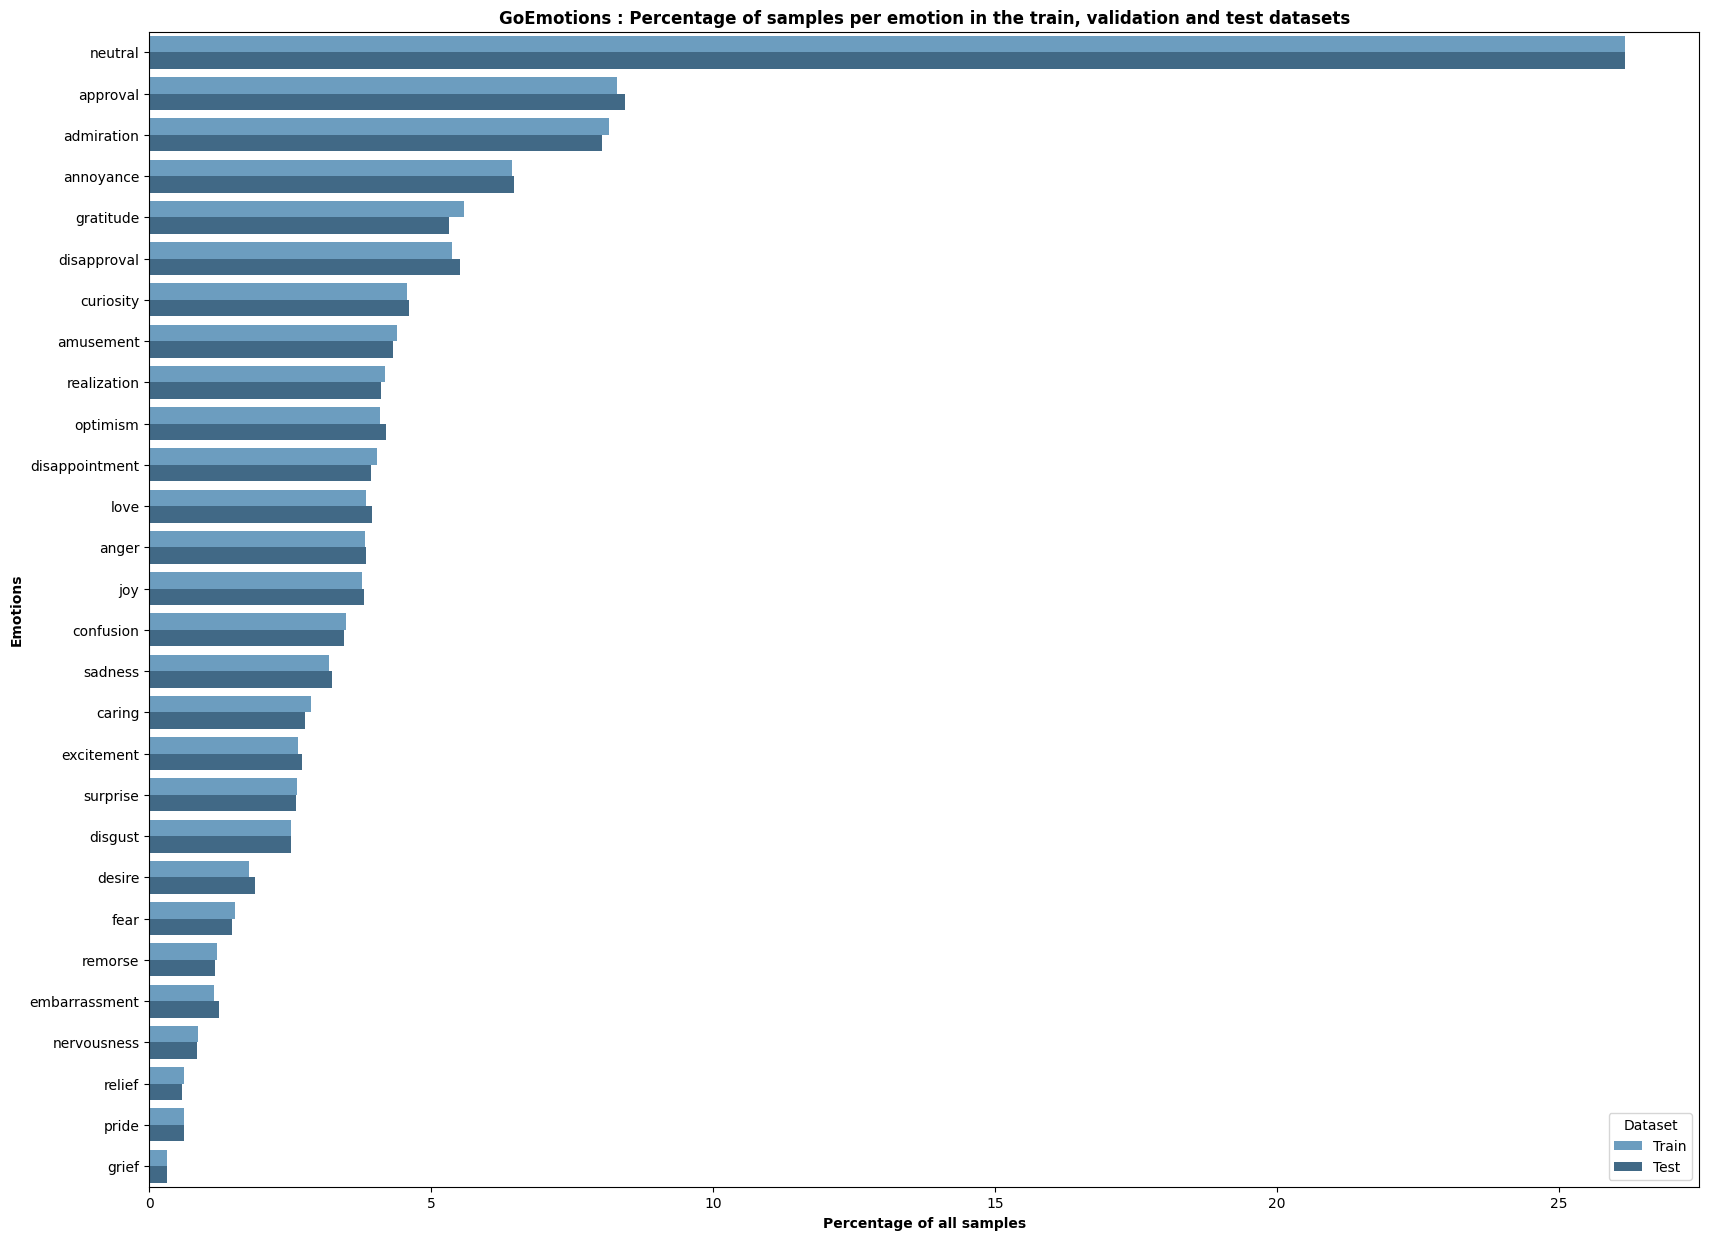

In [ ]:
# Class Balance visualization on GoEmotions
plt.figure(figsize=(20,15))
sns.barplot(x='Percentage', y='Emotion', data=balance_GE, orient='h', hue='Dataset', palette="Blues_d")
plt.title("GoEmotions : Percentage of samples per emotion in the train, validation and test datasets", fontweight='bold')
plt.ylabel("Emotions", fontweight='bold')
plt.xlabel("Percentage of all samples", fontweight='bold')
plt.show()

In [ ]:
X_train = df_train["cleaned_text"]
y_train = np.asarray(df_train[df_train.columns[2:]])
X_test = df_test["cleaned_text"]
y_test = np.asarray(df_test[df_test.columns[2:]])


In [ ]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=3000, max_df=0.85)
vectorizer.fit(X_train)

TfidfVectorizer(max_df=0.85, max_features=3000, stop_words='english')

In [ ]:
X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print(X_train_tfidf)
print('================================')
print(X_test_tfidf)

  (0, 1597)	0.8234317317483432
  (0, 1547)	0.2037076378201197
  (0, 1003)	0.28599215007948375
  (0, 336)	0.4457262293567495
  (1, 2973)	0.5351136344508365
  (1, 1260)	0.8447800886768204
  (2, 2423)	0.47671589366315154
  (2, 2300)	0.5048375227328195
  (2, 1827)	0.45502093275921524
  (2, 1422)	0.4349986720843533
  (2, 1232)	0.3487307534556075
  (3, 2896)	0.3183005700475923
  (3, 1217)	0.3520284552778671
  (3, 692)	0.34600942165871257
  (3, 623)	0.45063294578668106
  (3, 402)	0.46035326602821713
  (3, 73)	0.489941846073829
  (4, 2593)	0.4763415782385865
  (4, 2470)	0.6474145856381806
  (4, 1298)	0.3618824777988361
  (4, 53)	0.4722225401294294
  (5, 2977)	0.5400008953122394
  (5, 1526)	0.8416644420800844
  (6, 2787)	0.5561207440555564
  (6, 1624)	0.3817310262380339
  :	:
  (147840, 183)	0.38451730239373755
  (147841, 2568)	0.5554726222431539
  (147841, 1784)	0.3302545518024561
  (147841, 1434)	0.3904376059002101
  (147841, 1267)	0.40514353636171185
  (147841, 1049)	0.5155572594730015
  (14

In [ ]:
# Multi-label classification
rc = RidgeClassifier(class_weight='balanced')
classifier = MultiOutputClassifier(rc, n_jobs=-1)
classifier.fit(X_train_tfidf, y_train)

MultiOutputClassifier(estimator=RidgeClassifier(class_weight='balanced'),
                      n_jobs=-1)

In [ ]:
# Predict on training data
train_preds = classifier.predict(X_train_tfidf)

# Check training accuracy
train_accuracy = accuracy_score(y_train, train_preds)
print('Training accuracy = {}'.format(train_accuracy))

# Generate classification report for training data
emotions = df_train.columns[2:]  # Assuming emotions are the columns from the third column onwards
print(classification_report(y_train, train_preds, target_names=emotions))


Training accuracy = 0.007900058844616394
                precision    recall  f1-score   support

    admiration       0.32      0.80      0.46     12046
     amusement       0.33      0.86      0.48      6504
         anger       0.16      0.83      0.27      5651
     annoyance       0.16      0.74      0.26      9516
      approval       0.17      0.69      0.27     12270
        caring       0.11      0.86      0.20      4251
     confusion       0.10      0.79      0.18      5172
     curiosity       0.11      0.77      0.19      6771
        desire       0.09      0.89      0.17      2629
disappointment       0.11      0.77      0.19      5978
   disapproval       0.12      0.74      0.21      7932
       disgust       0.12      0.87      0.20      3710
 embarrassment       0.06      0.93      0.11      1692
    excitement       0.10      0.85      0.18      3906
          fear       0.12      0.93      0.21      2264
     gratitude       0.49      0.89      0.63      8253
      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Making predictions on GoEmotions taxonomy
classifier_preds = classifier.predict(X_test_tfidf)
classifier_preds

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 1, 0]])

In [ ]:
emotions = list(emotions)

In [ ]:
# Check test accuracy
test_accuracy = accuracy_score(y_test, classifier_preds)
print('Test accuracy = {}'.format(test_accuracy))

## Show results
print(classification_report(y_test, classifier_preds, target_names=emotions))

Test accuracy = 0.007796224985796351
                precision    recall  f1-score   support

    admiration       0.30      0.75      0.42      5085
     amusement       0.30      0.78      0.44      2741
         anger       0.13      0.68      0.22      2433
     annoyance       0.14      0.63      0.22      4102
      approval       0.14      0.57      0.22      5350
        caring       0.08      0.67      0.15      1748
     confusion       0.08      0.59      0.14      2187
     curiosity       0.09      0.62      0.16      2921
        desire       0.07      0.66      0.13      1188
disappointment       0.08      0.61      0.14      2491
   disapproval       0.10      0.58      0.17      3492
       disgust       0.09      0.66      0.15      1591
 embarrassment       0.04      0.55      0.07       784
    excitement       0.08      0.65      0.14      1723
          fear       0.08      0.67      0.14       933
     gratitude       0.45      0.85      0.59      3372
         g

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def predict_samples(text_samples, model):

    # Text preprocessing and cleaning
    text_samples = pd.Series(text_samples)
    text_samples_clean = text_samples.apply(preprocess_corpus)

    # Create tfidf representation
    tfidf_text_samples_clean = vectorizer.transform(text_samples_clean)

    # labels predictions
    samples_pred_labels = model.predict(tfidf_text_samples_clean)
    samples_pred_labels_df = pd.DataFrame(samples_pred_labels)
    samples_pred_labels_df = samples_pred_labels_df.apply(lambda x: [emotions[i] for i in range(len(x)) if x[i]==1], axis=1)

    return pd.DataFrame({"Text":text_samples, "Emotions":list(samples_pred_labels_df)})



In [ ]:
# Predict samples
test_text = df_train.sample(5)
test_text = test_text["cleaned_text"].values.tolist()
predict_samples(test_text, classifier)

,Text,Emotions
0,"pennsylvania here, i have been doing this sinc...","[curiosity, pride, neutral]"
1,"i am a leftleaning libertarian, and it annoys ...","[annoyance, approval, caring, disapproval, fea..."
2,"bzzzzt, try again","[caring, curiosity, desire, optimism, neutral]"
3,i like your rant.,"[admiration, annoyance, curiosity, love, pride..."
4,this is not even them not getting it. they jus...,"[amusement, annoyance, caring, disappointment,..."


# **IMPROVED VERSION**

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer




In [ ]:
train_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles/full_dataset/train_dataset.csv'
validation_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles/full_dataset/validation_dataset.csv'
test_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles/full_dataset/test_dataset.csv'
#Loading datasets into DF
df_train = pd.read_csv(train_dataset_path)
validation_df = pd.read_csv(validation_dataset_path)
test_df = pd.read_csv(test_dataset_path)
# Prepare datasets
X_train = df_train["cleaned_text"]
y_train = np.asarray(df_train[df_train.columns[2:]])
X_val = validation_df["cleaned_text"]
y_val = np.asarray(validation_df[validation_df.columns[2:]])
X_test = test_df["cleaned_text"]
y_test = np.asarray(test_df[test_df.columns[2:]])

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words="english", max_features=3000, max_df=0.85)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Hyperparameter tuning for RidgeClassifier
param_grid = {'estimator__alpha': [0.1, 1, 10, 100]}
rc = RidgeClassifier(class_weight='balanced')
classifier = MultiOutputClassifier(rc, n_jobs=-1)
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_tfidf, y_train)

best_classifier = grid_search.best_estimator_

# Train on full training data
best_classifier.fit(X_train_tfidf, y_train)


MultiOutputClassifier(estimator=RidgeClassifier(alpha=100,
                                                class_weight='balanced'),
                      n_jobs=-1)

In [ ]:

# Predictions
train_preds = best_classifier.predict(X_train_tfidf)
val_preds = best_classifier.predict(X_val_tfidf)
test_preds = best_classifier.predict(X_test_tfidf)

# Evaluate performance
train_f1 = classification_report(y_train, train_preds, target_names=emotions)
val_f1 = classification_report(y_val, val_preds, target_names=emotions)
test_f1 = classification_report(y_test, test_preds, target_names=emotions)

print("Training F1 Score:\n", train_f1)
print("Validation F1 Score:\n", val_f1)
print("Test F1 Score:\n", test_f1)



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Training F1 Score:
                 precision    recall  f1-score   support

    admiration       0.36      0.73      0.48     12046
     amusement       0.49      0.79      0.60      6504
         anger       0.18      0.73      0.29      5651
     annoyance       0.16      0.69      0.26      9516
      approval       0.17      0.61      0.26     12270
        caring       0.11      0.74      0.19      4251
     confusion       0.11      0.67      0.18      5172
     curiosity       0.11      0.66      0.19      6771
        desire       0.11      0.73      0.19      2629
disappointment       0.11      0.69      0.19      5978
   disapproval       0.11      0.70      0.19      7932
       disgust       0.13      0.73      0.23      3710
 embarrassment       0.06      0.77      0.12      1692
    excitement       0.11      0.72      0.19      3906
          fear       0.17      0.78      0.28      2264
     gratitude       0.62      0.84      0.71      8253
         grief       0.05  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Analyzing Misclassifications
conf_matrix = confusion_matrix(y_test.argmax(axis=1), test_preds.argmax(axis=1))
print("Confusion Matrix:\n", conf_matrix)



In [ ]:

# Predict function for new samples
def predict_samples(text_samples, model):
    text_samples_clean = pd.Series(text_samples).apply(preprocess_corpus)
    tfidf_text_samples_clean = vectorizer.transform(text_samples_clean)
    samples_pred_labels = model.predict(tfidf_text_samples_clean)
    samples_pred_labels_df = pd.DataFrame(samples_pred_labels)
    samples_pred_labels_df = samples_pred_labels_df.apply(lambda x: [emotions[i] for i in range(len(x)) if x[i]==1], axis=1)
    return pd.DataFrame({"Text": text_samples, "Emotions": list(samples_pred_labels_df)})

# Predict new samples
test_text = df_train.sample(5)["cleaned_text"].values.tolist()
print(predict_samples(test_text, best_classifier))

                                                Text  \
0                       excuse me is this an analogy   
1                          do you work in education?   
2  i just went to post this but you beat me to it...   
3  same here. my refund almost doubled from last ...   
4  i have made the same exact comment before its ...   

                                            Emotions  
0  [annoyance, confusion, curiosity, disapproval,...  
1  [curiosity, disappointment, disapproval, sadne...  
2                                   [amusement, joy]  
3  [disappointment, fear, nervousness, realizatio...  
4                     [approval, confusion, neutral]  


## **Remove Neutral Class**  ** Improved One Version**

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
train_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles/full_dataset/train_dataset.csv'
validation_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles/full_dataset/validation_dataset.csv'
test_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles/full_dataset/test_dataset.csv'
#Loading datasets into DF
df_train = pd.read_csv(train_dataset_path)
validation_df = pd.read_csv(validation_dataset_path)
test_df = pd.read_csv(test_dataset_path)

# df_train = df_train.drop(columns=['neutral'])
# validation_df = validation_df.drop(columns=['neutral'])
# test_df = test_df.drop(columns=['neutral'])

# Drop the 'emotion' column
df_train = df_train.drop(columns=['emotion'], errors='ignore')
validation_df = validation_df.drop(columns=['emotion'], errors='ignore')
test_df = test_df.drop(columns=['emotion'], errors='ignore')

# Removing samples with only 0 in their labels
df_train = df_train.loc[ df_train.apply(lambda x: sum(x[1:]), axis=1)>0 ]
validation_df = validation_df.loc[ validation_df.apply(lambda x: sum(x[1:]), axis=1)>0 ]
test_df = test_df.loc[ test_df.apply(lambda x: sum(x[1:]), axis=1)>0 ]



In [ ]:

# Prepare datasets
X_train = df_train["cleaned_text"]
y_train = np.asarray(df_train[df_train.columns[1:]])
X_val = validation_df["cleaned_text"]
y_val = np.asarray(validation_df[validation_df.columns[1:]])
X_test = test_df["cleaned_text"]
y_test = np.asarray(test_df[test_df.columns[1:]])

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words="english", max_features=3000, max_df=0.85)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Hyperparameter tuning for RidgeClassifier
param_grid = {'estimator__alpha': [0.1, 1, 10, 100]}
rc = RidgeClassifier(class_weight='balanced')
classifier = MultiOutputClassifier(rc, n_jobs=-1)
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_tfidf, y_train)

best_classifier = grid_search.best_estimator_

# Train on full training data
best_classifier.fit(X_train_tfidf, y_train)


MultiOutputClassifier(estimator=RidgeClassifier(alpha=100,
                                                class_weight='balanced'),
                      n_jobs=-1)

In [ ]:
# Predictions
train_preds = best_classifier.predict(X_train_tfidf)
val_preds = best_classifier.predict(X_val_tfidf)
test_preds = best_classifier.predict(X_test_tfidf)

# Evaluate performance
train_f1 = classification_report(y_train, train_preds, target_names=emotions)
val_f1 = classification_report(y_val, val_preds, target_names=emotions)
test_f1 = classification_report(y_test, test_preds, target_names=emotions)

print("Training F1 Score:\n", train_f1)
print("Validation F1 Score:\n", val_f1)
print("Test F1 Score:\n", test_f1)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training F1 Score:
                 precision    recall  f1-score   support

    admiration       0.36      0.73      0.48     12046
     amusement       0.49      0.79      0.61      6504
         anger       0.18      0.72      0.29      5651
     annoyance       0.16      0.69      0.26      9516
      approval       0.17      0.61      0.26     12270
        caring       0.11      0.74      0.19      4251
     confusion       0.11      0.67      0.19      5172
     curiosity       0.12      0.66      0.20      6771
        desire       0.11      0.73      0.19      2629
disappointment       0.11      0.69      0.19      5978
   disapproval       0.11      0.70      0.20      7932
       disgust       0.14      0.73      0.23      3710
 embarrassment       0.06      0.77      0.12      1692
    excitement       0.11      0.72      0.19      3906
          fear       0.18      0.78      0.29      2264
     gratitude       0.62      0.84      0.72      8253
         grief       0.05  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Analyzing Misclassifications
conf_matrix = confusion_matrix(y_test.argmax(axis=1), test_preds.argmax(axis=1))
print("Confusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[1830   34   65  101  187   58   42   43   21   22   15    5    3   27
     2   19    1   10   15    1    4    4    6    2    0    2    0   32]
 [ 151  988   36   37   38   13   18   16    5    6    5    1    0    6
     1    4    0    3    0    1    0    2    2    0    0    0    1    9]
 [  46   36  767  135   50   26   36   23    7   14   11    3    4    8
     3    2    2    0    1    0    1    1    0    0    0    0    0   26]
 [ 116   71  640  422  157   52   83   52   15   38   22    2    1    8
     3    6    4    3    4    2    1    3    4    1    1    1    4   33]
 [ 396   54  231  365  730  126  118   79   25   50   27    5    6   19
     7   17    3   10    6    3    2    5   14    3    0    2    3   56]
 [ 112   16   83   86  138  183   24   12    5   11    6    1    2    0
     1    3    2    1    1    0    1    1    2    0    0    0    0    8]
 [  64   32  101  188  217   49  224   51    4   14   11    1    0    2
     5    5    0    0    3    0    3   

In [ ]:

# Predict function for new samples
def predict_samples(text_samples, model):
    text_samples_clean = pd.Series(text_samples).apply(preprocess_corpus)
    tfidf_text_samples_clean = vectorizer.transform(text_samples_clean)
    samples_pred_labels = model.predict(tfidf_text_samples_clean)
    samples_pred_labels_df = pd.DataFrame(samples_pred_labels)
    samples_pred_labels_df = samples_pred_labels_df.apply(lambda x: [emotions[i] for i in range(len(x)) if x[i]==1], axis=1)
    return pd.DataFrame({"Text": text_samples, "Emotions": list(samples_pred_labels_df)})

# Predict new samples
test_text = df_train.sample(5)["cleaned_text"].values.tolist()
print(predict_samples(test_text, best_classifier))

                                                Text  \
0  its lunacy to think that name is an actual rus...   
1  check her hormones. if they are normal then yo...   
2  thanks for sharing! i loved name interview too...   
3            me too. they just slow everything down.   
4  yeah, the golden nugget is get over yourself a...   

                                            Emotions  
0  [annoyance, confusion, curiosity, disappointme...  
1  [approval, caring, curiosity, desire, fear, op...  
2  [admiration, amusement, excitement, gratitude,...  
3  [annoyance, caring, disappointment, embarrassm...  
4  [approval, disappointment, pride, realization,...  
